In [2]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

thebrokenvessel_adl_project_path = kagglehub.dataset_download('thebrokenvessel/adl-project')

print('Data source import complete.')


100%|██████████| 1.87G/1.87G [00:14<00:00, 135MB/s]

Extracting files...


Data source import complete.


## Exploratory Data Analysis

Each subject has 14 recording runs (S001R01.edf through S001R14.edf). Each EDF file has a corresponding .event file with annotations. This 14 recordings mean:

1. Baseline, eyes open
2. Baseline, eyes closed
3. Task 1 (open and close left or right fist)
4. Task 2 (imagine opening and closing left or right fist)
5. Task 3 (open and close both fists or both feet)
6. Task 4 (imagine opening and closing both fists or both feet)
7. Task 1
8. Task 2
9. Task 3
10. Task 4
11. Task 1
12. Task 2
13. Task 3
14. Task 4


The [data](https://physionet.org/content/eegmmidb/1.0.0/S001/#files-panel) are provided here in EDF+ format (containing 64 EEG signals, each sampled at 160 samples per second, and an annotation channel). For use with PhysioToolkit software, rdedfann generated a separate PhysioBank-compatible annotation file (with the suffix .event) for each recording. The .event files and the annotation channels in the corresponding .edf files contain identical data.

Each annotation includes one of three codes (T0, T1, or T2):

- __T0__ corresponds to rest
- __T1__ corresponds to onset of motion (real or imagined) of
          - the left fist (in runs 3, 4, 7, 8, 11, and 12)
          - both fists (in runs 5, 6, 9, 10, 13, and 14)
- __T2__ corresponds to onset of motion (real or imagined) of
          - the right fist (in runs 3, 4, 7, 8, 11, and 12)
          - both feet (in runs 5, 6, 9, 10, 13, and 14)

## Import libraries

In [4]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 59.5 MB/s eta 0:00:00


In [5]:
# Cell 1: Import Libraries
import mne
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch

In [6]:
# List the contents of the downloaded dataset
import os
print('Files downloaded to:', thebrokenvessel_adl_project_path)
print('Listing contents:')
print(os.listdir(thebrokenvessel_adl_project_path))

base_path = f'{thebrokenvessel_adl_project_path}/files'
print(f'{os.listdir(base_path)}')

Files downloaded to: /root/.cache/kagglehub/datasets/thebrokenvessel/adl-project/versions/1
Listing contents:
['files']
['SHA256SUMS.txt', 'S014', 'S008', 'S061', 'S045', 'S090', 'wfdbcal', 'S053', 'S036', 'S042', 'S059', 'S022', 'S024', 'S047', 'S089', 'S051', 'S071', 'S067', 'S033', 'S046', 'S098', 'S044', 'S043', 'S102', 'S048', 'S064', 'S015', 'S104', 'S084', 'S050', 'S005', 'S037', 'S019', 'S028', 'S074', 'S007', 'S082', 'S026', 'S006', 'S079', 'S093', 'S010', 'S106', 'S107', 'S030', 'S013', 'S088', 'S052', 'S096', 'S072', 'S062', 'S073', 'S034', 'S009', 'S097', 'S012', 'S021', 'S068', 'S004', 'S069', 'S040', 'RECORDS', 'S003', 'S017', 'S083', 'S075', 'S065', 'S027', 'S081', 'S103', 'S018', 'S025', 'S094', 'S076', 'S095', 'S077', 'S070', 'S056', 'S011', 'S032', 'S100', 'S060', 'S101', 'S049', 'S085', 'S063', 'S058', 'ANNOTATORS', 'S099', 'S092', 'S091', 'S035', 'S086', 'S039', 'S020', 'S055', '64_channel_sharbrough-old.png', 'S002', 'S080', 'S041', '64_channel_sharbrough.png', 'S0

## Setup Paths & Functions

In [7]:
# Cell 2: Setup Paths and Functions
# Base path to the dataset
base_path = '/kaggle/input/adl-project/files'
base_path = f'{thebrokenvessel_adl_project_path}/files'

# Function to explore a single EDF file
def explore_edf_file(file_path):
    print(f"Extracting EDF parameters from {file_path}...")

    # Load the EDF file
    raw = mne.io.read_raw_edf(file_path, preload=True)

    # Basic information
    print(f"File: {os.path.basename(file_path)}")
    print(f"Duration: {raw.times[-1]:.2f} seconds")
    print(f"Sampling rate: {raw.info['sfreq']} Hz")
    print(f"Number of channels: {len(raw.ch_names)}")

    # Extract events
    events, event_id = mne.events_from_annotations(raw)
    print(f"Used Annotations descriptions: {list(event_id.keys())}")
    print(f"Events: {event_id}")
    print(f"Number of events: {len(events)}")

    # Count each event type
    event_counts = {}
    for event in events:
        event_type = event[2]
        event_counts[event_type] = event_counts.get(event_type, 0) + 1

    print("Event counts:")
    for event_type, count in event_counts.items():
        print(f"  Type {event_type}: {count}")

    return raw, events, event_id

# Function to find channel names for C3, Cz, C4
def find_central_channels(raw):
    # Print channel list for debugging
    print("First 10 channel names:")
    for i, ch in enumerate(raw.ch_names[:10]):
        print(f"  {i}: {ch}")

    # Convert all channel names to lowercase for case-insensitive matching
    ch_names_lower = [ch.lower() for ch in raw.ch_names]

    # Try different patterns for matching central channels
    c3_patterns = ['c3', 'c3-', 'eeg c3', 'eeg-c3']
    cz_patterns = ['cz', 'cz-', 'eeg cz', 'eeg-cz']
    c4_patterns = ['c4', 'c4-', 'eeg c4', 'eeg-c4']

    # Look for matches with any of the patterns
    c3_candidates = []
    cz_candidates = []
    c4_candidates = []

    for i, ch in enumerate(ch_names_lower):
        # C3 matching
        if any(pattern in ch for pattern in c3_patterns):
            c3_candidates.append(raw.ch_names[i])
        # Cz matching
        if any(pattern in ch for pattern in cz_patterns):
            cz_candidates.append(raw.ch_names[i])
        # C4 matching
        if any(pattern in ch for pattern in c4_patterns):
            c4_candidates.append(raw.ch_names[i])

    # Use the first match for each or None if not found
    c3 = c3_candidates[0] if c3_candidates else None
    cz = cz_candidates[0] if cz_candidates else None
    c4 = c4_candidates[0] if c4_candidates else None

    # If standard channels not found, try position-based as fallback
    if not any([c3, cz, c4]):
        # Just use the first few channels for demonstration
        print("No central channels found by name. Using first few channels instead.")
        if len(raw.ch_names) >= 3:
            return raw.ch_names[0], raw.ch_names[1], raw.ch_names[2]

    return c3, cz, c4

# Define run descriptions
run_descriptions = {
    1: "Baseline, eyes open",
    2: "Baseline, eyes closed",
    3: "Task 1 (open and close left or right fist)",
    4: "Task 2 (imagine opening and closing left or right fist)",
    5: "Task 3 (open and close both fists or both feet)",
    6: "Task 4 (imagine opening and closing both fists or both feet)",
    7: "Task 1 (repeat)",
    8: "Task 2 (repeat)",
    9: "Task 3 (repeat)",
    10: "Task 4 (repeat)",
    11: "Task 1 (repeat)",
    12: "Task 2 (repeat)",
    13: "Task 3 (repeat)",
    14: "Task 4 (repeat)"
}


## RUN 1  - Baseline, eyes open


--------------------------------------------------
Run 1: Baseline, eyes open
--------------------------------------------------
Extracting EDF parameters from /root/.cache/kagglehub/datasets/thebrokenvessel/adl-project/versions/1/files/S001/S001R01.edf...
Extracting EDF parameters from /root/.cache/kagglehub/datasets/thebrokenvessel/adl-project/versions/1/files/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
File: S001R01.edf
Duration: 60.99 seconds
Sampling rate: 160.0 Hz
Number of channels: 64
Used Annotations descriptions: [np.str_('T0')]
Used Annotations descriptions: [np.str_('T0')]
Events: {np.str_('T0'): 1}
Number of events: 1
Event counts:
  Type 1: 1

All available channels:
['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 'Fp1.', 'Fpz.', 'Fp2.', 'A

<ipython-input-8-e0fa73f7c44d>:44: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=50, picks=central_channels)


<Figure size 1500x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

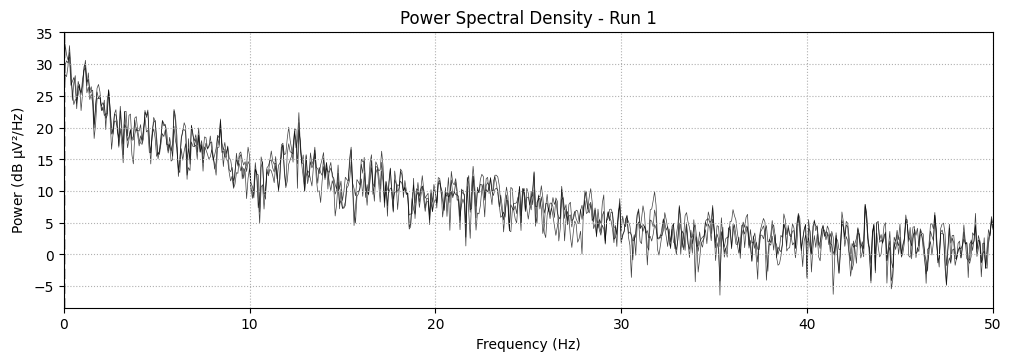

In [8]:
# Cell 3: Load and Analyze Run 1 (Baseline, eyes open)
run_num = 1
subject_id = 'S001'
file_path = os.path.join(base_path, subject_id, f"{subject_id}R{run_num:02d}.edf")

print(f"\n{'-'*50}")
print(f"Run {run_num}: {run_descriptions[run_num]}")
print(f"{'-'*50}")

raw, events, event_id = explore_edf_file(file_path)

# Print all channel names for reference
print("\nAll available channels:")
print(raw.ch_names)

# Find central channels
c3, cz, c4 = find_central_channels(raw)
print(f"\nDetected central channels: C3={c3}, Cz={cz}, C4={c4}")

# Use the channels we found (or first few if none found)
central_channels = [ch for ch in [c3, cz, c4] if ch is not None]
if not central_channels:
    print("Using first 3 channels instead")
    central_channels = raw.ch_names[:3]

# Plot 5 seconds of raw data
plt.figure(figsize=(15, 6))
try:
    data, times = raw.get_data(picks=central_channels, start=0, stop=int(5*raw.info['sfreq']))
    for i, ch_name in enumerate(central_channels):
        plt.plot(times, data[i] + i*200, label=ch_name)
    plt.title(f"5 seconds of EEG data - Run {run_num}: {run_descriptions[run_num]}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()
except Exception as e:
    print(f"Error plotting raw data: {e}")

# Plot power spectral density
plt.figure(figsize=(12, 5))
try:
    raw.plot_psd(fmax=50, picks=central_channels)
    plt.title(f"Power Spectral Density - Run {run_num}")
    plt.show()
except Exception as e:
    print(f"Error plotting PSD: {e}")


## Function to anaylse any run

In [9]:
# Cell 4: Function to analyze a specific run
def analyze_run(subject_id, run_num):
    """Analyze a specific run for a subject"""
    file_path = os.path.join(base_path, subject_id, f"{subject_id}R{run_num:02d}.edf")

    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None

    print(f"\n{'-'*50}")
    print(f"Run {run_num}: {run_descriptions[run_num]}")
    print(f"{'-'*50}")

    # Load data and extract events
    raw, events, event_id = explore_edf_file(file_path)

    # Find central channels
    c3, cz, c4 = find_central_channels(raw)
    print(f"\nDetected central channels: C3={c3}, Cz={cz}, C4={c4}")

    # Use the channels we found (or first few if none found)
    central_channels = [ch for ch in [c3, cz, c4] if ch is not None]
    if not central_channels:
        print("Using first 3 channels instead")
        central_channels = raw.ch_names[:3]

    # Plot 5 seconds of raw data
    plt.figure(figsize=(15, 6))
    try:
        data, times = raw.get_data(picks=central_channels, start=0, stop=int(5*raw.info['sfreq']))
        for i, ch_name in enumerate(central_channels):
            plt.plot(times, data[i] + i*200, label=ch_name)
        plt.title(f"5 seconds of EEG data - Run {run_num}: {run_descriptions[run_num]}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(True)
        plt.show()
    except Exception as e:
        print(f"Error plotting raw data: {e}")

    # Plot power spectral density
    plt.figure(figsize=(12, 5))
    try:
        raw.plot_psd(fmax=50, picks=central_channels)
        plt.title(f"Power Spectral Density - Run {run_num}")
        plt.show()
    except Exception as e:
        print(f"Error plotting PSD: {e}")

    # If run contains motor tasks, analyze epochs
    if run_num >= 3:  # All runs from 3 onwards have motor tasks
        # Define event mapping based on run type
        if run_num in [3, 4, 7, 8, 11, 12]:  # Left/Right tasks
            event_dict = {'T1': 1, 'T2': 2}  # T1: Left, T2: Right
            print("T1: Left fist, T2: Right fist")
        else:  # Both fists/feet tasks
            event_dict = {'T1': 1, 'T2': 2}  # T1: Both fists, T2: Both feet
            print("T1: Both fists, T2: Both feet")

        # Check if we have any of these events
        has_events = False
        for code in event_dict.values():
            if np.any(events[:, 2] == code):
                has_events = True
                break

        if not has_events:
            print(f"No events of types {list(event_dict.values())} found in this run")
            return raw

        try:
            # Create epochs
            print(f"Creating epochs with events: {event_dict}")
            print("Number of events by type:")
            for event_name, event_code in event_dict.items():
                count = np.sum(events[:, 2] == event_code)
                print(f"  {event_name} (code {event_code}): {count} events")

            epochs = mne.Epochs(
                raw,
                events,
                event_id=event_dict,
                tmin=-1.0,  # Start 1 second before event
                tmax=3.0,   # End 3 seconds after event
                baseline=(-1.0, 0),  # Use pre-stimulus period as baseline
                preload=True,
                reject=None,  # Don't automatically reject any epochs
                flat=None     # Don't reject based on flatness
            )

            # Process each event type
            for event_name, event_code in event_dict.items():
                if event_name in epochs.event_id:
                    # Skip if no events of this type
                    if len(epochs[event_name]) == 0:
                        print(f"No epochs for {event_name}")
                        continue

                    print(f"Processing {len(epochs[event_name])} epochs for {event_name}")

                    # Plot ERP
                    try:
                        evoked = epochs[event_name].average()
                        plt.figure(figsize=(12, 5))
                        evoked.plot(picks=central_channels)
                        plt.title(f"Average ERP - Run {run_num}, {event_name}")
                        plt.show()
                    except Exception as e:
                        print(f"Error plotting ERP: {e}")

                    # Plot time-frequency representation
                    try:
                        freqs = np.linspace(4, 40, 10)  # Fewer frequency points for faster computation
                        n_cycles = freqs / 2.

                        # Using the new compute_tfr method
                        power = epochs[event_name].compute_tfr(
                            method="morlet",
                            freqs=freqs,
                            n_cycles=n_cycles,
                            use_fft=True,
                            return_itc=False,
                            average=True,
                            picks=central_channels
                        )

                        plt.figure(figsize=(12, 5))
                        power.plot(picks=[0], baseline=(-0.5, 0), mode='logratio',
                                 title=f"Time-Frequency Analysis - Run {run_num}, {event_name}")
                        plt.show()
                    except Exception as e:
                        print(f"Error in time-frequency analysis: {e}")
        except Exception as e:
            print(f"Error creating epochs: {e}")

    return raw


## run 2 - Baseline, eyes closed


--------------------------------------------------
Run 2: Baseline, eyes closed
--------------------------------------------------
Extracting EDF parameters from /root/.cache/kagglehub/datasets/thebrokenvessel/adl-project/versions/1/files/S001/S001R02.edf...
Extracting EDF parameters from /root/.cache/kagglehub/datasets/thebrokenvessel/adl-project/versions/1/files/S001/S001R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
File: S001R02.edf
Duration: 60.99 seconds
Sampling rate: 160.0 Hz
Number of channels: 64
Used Annotations descriptions: [np.str_('T0')]
Used Annotations descriptions: [np.str_('T0')]
Events: {np.str_('T0'): 1}
Number of events: 1
Event counts:
  Type 1: 1
First 10 channel names:
  0: Fc5.
  1: Fc3.
  2: Fc1.
  3: Fcz.
  4: Fc2.
  5: Fc4.
  6: Fc6.
  7: C5..
  8: C3..
  9: C1..

Detected central channels: C3=Fc3., Cz=Fcz., C4=Fc4.
Error plotting raw data: too many values

<ipython-input-9-7eab49f12be1>:45: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=50, picks=central_channels)


<Figure size 1500x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

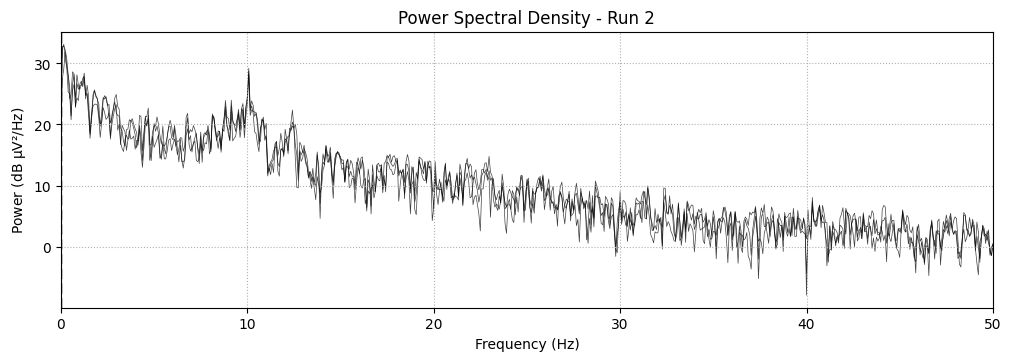

In [10]:
# Cell 5: Analyze Run 2 (Baseline, eyes closed)
_ = analyze_run('S001', 2)

## RUN 3 - Open and close left or right fist


--------------------------------------------------
Run 3: Task 1 (open and close left or right fist)
--------------------------------------------------
Extracting EDF parameters from /root/.cache/kagglehub/datasets/thebrokenvessel/adl-project/versions/1/files/S001/S001R03.edf...
Extracting EDF parameters from /root/.cache/kagglehub/datasets/thebrokenvessel/adl-project/versions/1/files/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
File: S001R03.edf
Duration: 124.99 seconds
Sampling rate: 160.0 Hz
Number of channels: 64
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}
Number of events: 30
Event counts:
  Type 1: 15
  Type 3: 7
  Type 2: 8
First 10 channel names:
  0: Fc5.
  1: Fc3.
  2: Fc1.
  3: Fcz.
  4: Fc2.

<ipython-input-9-7eab49f12be1>:45: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=50, picks=central_channels)


<Figure size 1500x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

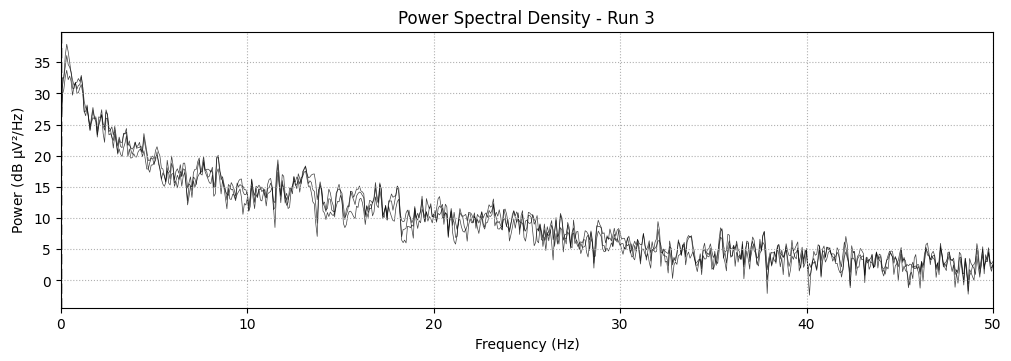

T1: Left fist, T2: Right fist
Creating epochs with events: {'T1': 1, 'T2': 2}
Number of events by type:
  T1 (code 1): 15 events
  T2 (code 2): 8 events
Not setting metadata
23 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 23 events and 641 original time points ...
1 bad epochs dropped
Processing 14 epochs for T1


<Figure size 1200x500 with 0 Axes>

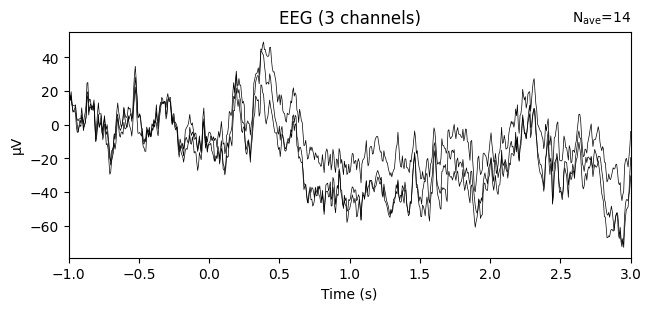

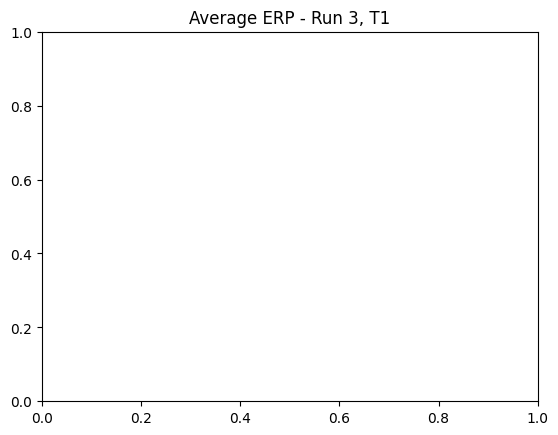

Applying baseline correction (mode: logratio)


<Figure size 1200x500 with 0 Axes>

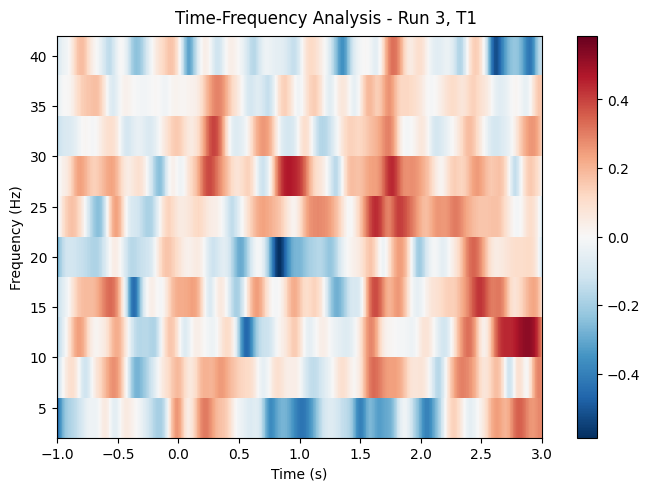

Processing 8 epochs for T2


<Figure size 1200x500 with 0 Axes>

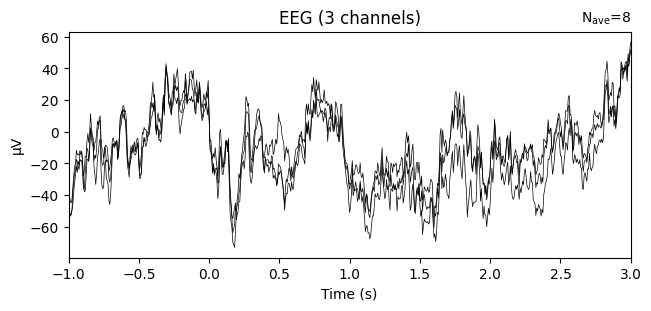

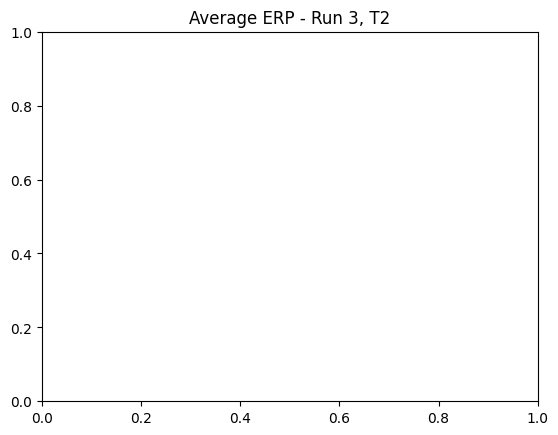

Applying baseline correction (mode: logratio)


<Figure size 1200x500 with 0 Axes>

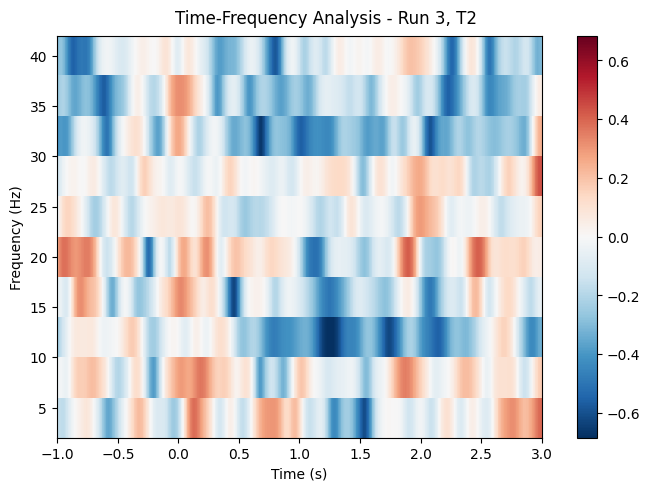

In [11]:
# Cell 6: Analyze Run 3 (First motor task - open and close left or right fist)
_ = analyze_run('S001', 3)

## Run 4 (Motor imagery task - imagine opening and closing left or right fist)


--------------------------------------------------
Run 4: Task 2 (imagine opening and closing left or right fist)
--------------------------------------------------
Extracting EDF parameters from /root/.cache/kagglehub/datasets/thebrokenvessel/adl-project/versions/1/files/S001/S001R04.edf...
Extracting EDF parameters from /root/.cache/kagglehub/datasets/thebrokenvessel/adl-project/versions/1/files/S001/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
File: S001R04.edf
Duration: 124.99 seconds
Sampling rate: 160.0 Hz
Number of channels: 64
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}
Number of events: 30
Event counts:
  Type 1: 15
  Type 3: 7
  Type 2: 8
First 10 channel names:
  0: Fc5.
  1: Fc3.
  2: Fc1.
  3: F

<ipython-input-9-7eab49f12be1>:45: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=50, picks=central_channels)


<Figure size 1500x600 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

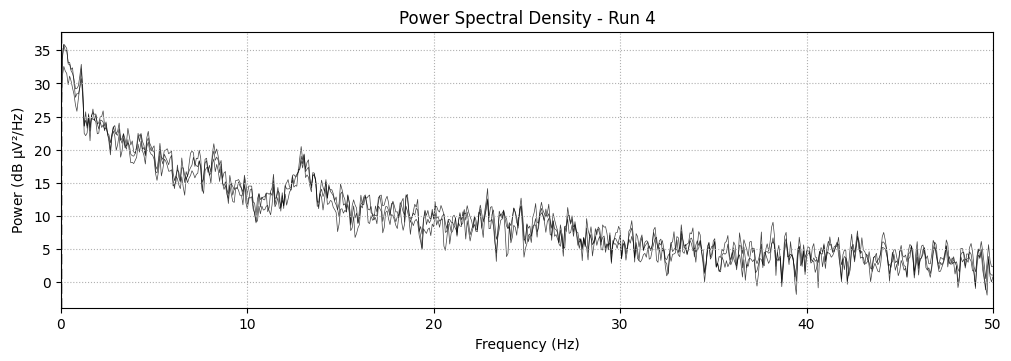

T1: Left fist, T2: Right fist
Creating epochs with events: {'T1': 1, 'T2': 2}
Number of events by type:
  T1 (code 1): 15 events
  T2 (code 2): 8 events
Not setting metadata
23 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 23 events and 641 original time points ...
1 bad epochs dropped
Processing 14 epochs for T1


<Figure size 1200x500 with 0 Axes>

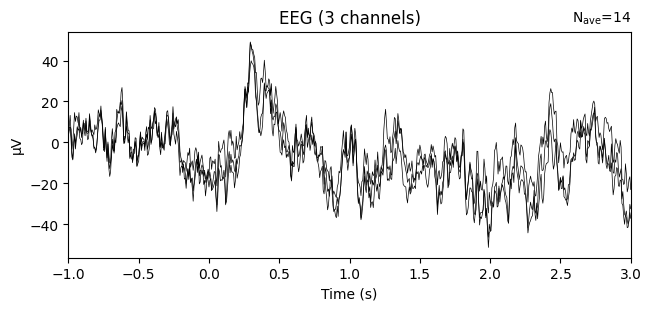

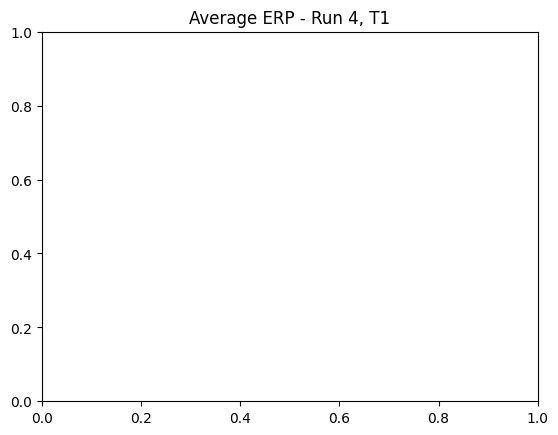

Applying baseline correction (mode: logratio)


<Figure size 1200x500 with 0 Axes>

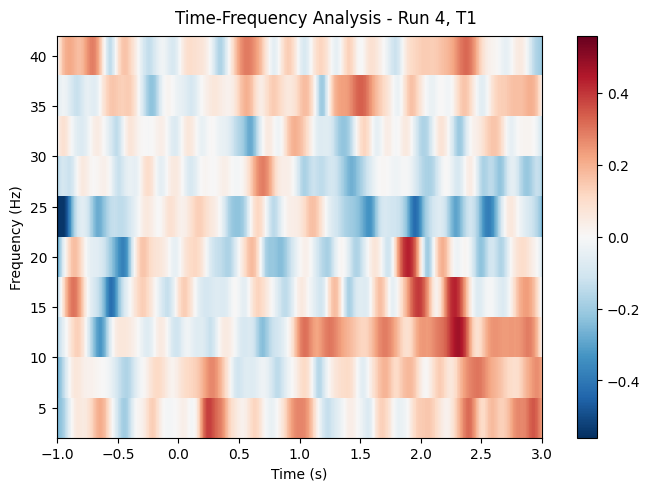

Processing 8 epochs for T2


<Figure size 1200x500 with 0 Axes>

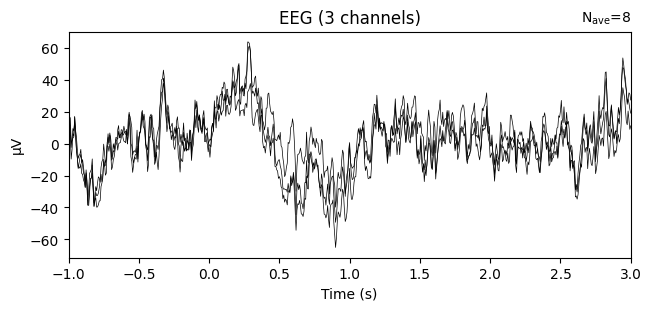

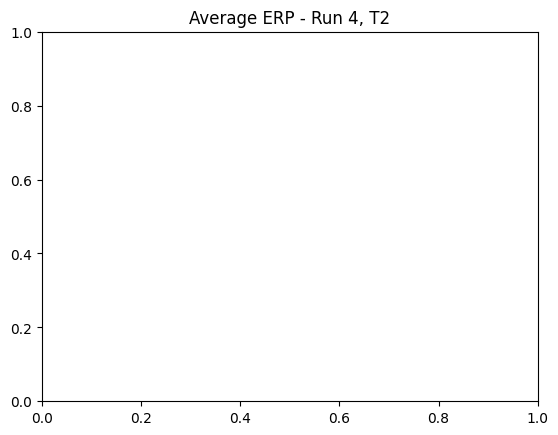

Applying baseline correction (mode: logratio)


<Figure size 1200x500 with 0 Axes>

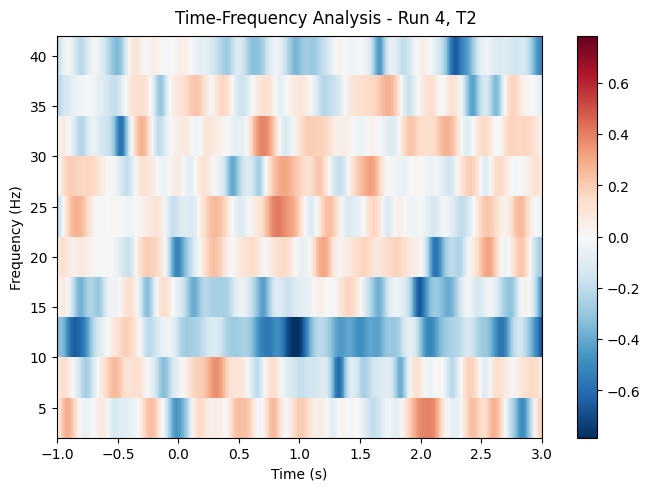

In [12]:


# Cell 7: Analyze Run 4 (Motor imagery task - imagine opening and closing left or right fist)
_ = analyze_run('S001', 4)

# Cell 8: Analyze a Specific Run (customize as needed)
# Example: Analyze Run 5 (open and close both fists or both feet)
# _ = analyze_run('S001', 5)

## Batch Analysis


Analyzing Run 1: Baseline, eyes open
Extracting EDF parameters from /root/.cache/kagglehub/datasets/thebrokenvessel/adl-project/versions/1/files/S001/S001R01.edf...
Extracting EDF parameters from /root/.cache/kagglehub/datasets/thebrokenvessel/adl-project/versions/1/files/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
File: S001R01.edf
Duration: 60.99 seconds
Sampling rate: 160.0 Hz
Number of channels: 64
Used Annotations descriptions: [np.str_('T0')]
Used Annotations descriptions: [np.str_('T0')]
Events: {np.str_('T0'): 1}
Number of events: 1
Event counts:
  Type 1: 1

Analyzing Run 2: Baseline, eyes closed
Extracting EDF parameters from /root/.cache/kagglehub/datasets/thebrokenvessel/adl-project/versions/1/files/S001/S001R02.edf...
Extracting EDF parameters from /root/.cache/kagglehub/datasets/thebrokenvessel/adl-project/versions/1/files/S001/S001R02.edf...
EDF file detecte

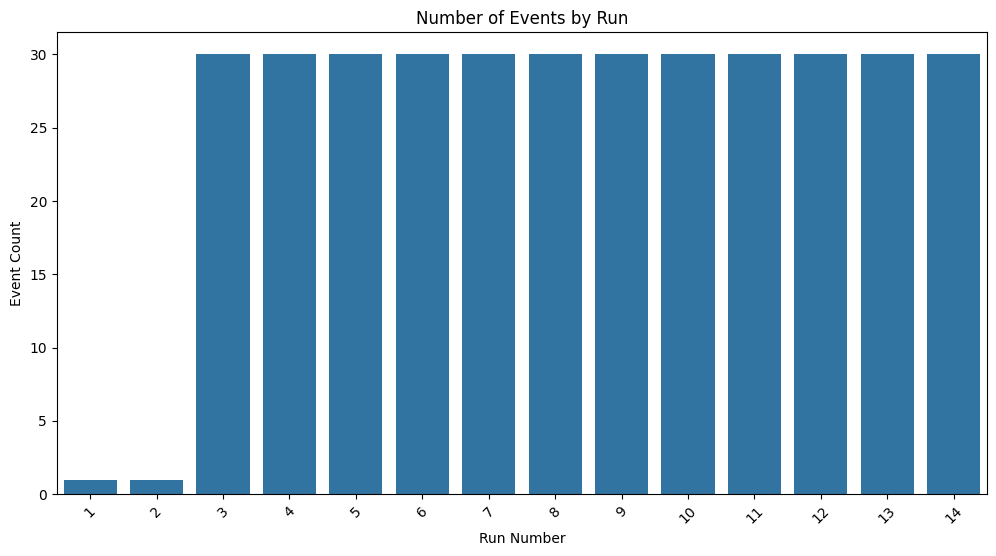

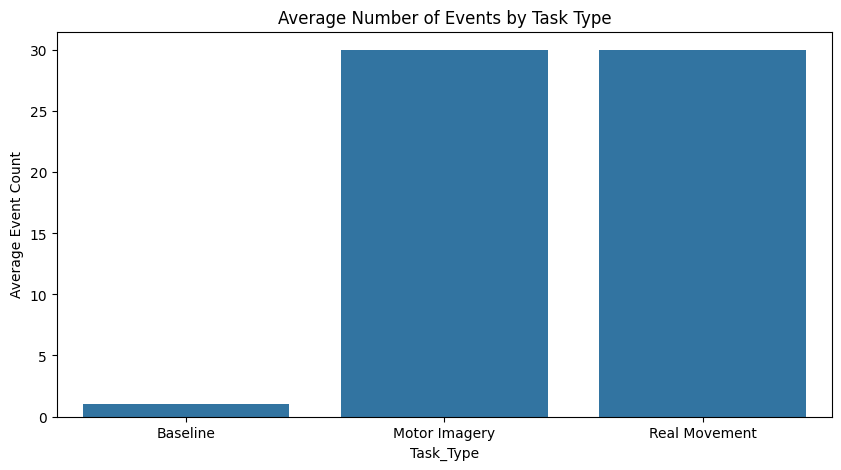


Summary Statistics by Run Type:
              n_events        duration     
                  mean  std       mean  std
Task_Type                                  
Baseline           1.0  0.0   60.99375  0.0
Motor Imagery     30.0  0.0  124.99375  0.0
Real Movement     30.0  0.0  124.99375  0.0


In [13]:
# Cell 9: Batch Analysis (Optional)
# If you want to run all analysis at once for summary statistics
def batch_analyze_runs(subject_id, run_numbers):
    # Initialize dictionaries to collect analysis data
    run_stats = {}
    event_stats = {}

    # Analyze each run
    for run_num in run_numbers:
        file_path = os.path.join(base_path, subject_id, f"{subject_id}R{run_num:02d}.edf")

        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue

        print(f"\nAnalyzing Run {run_num}: {run_descriptions[run_num]}")
        raw, events, event_id = explore_edf_file(file_path)

        # Store basic run statistics
        run_stats[run_num] = {
            'duration': raw.times[-1],
            'n_channels': len(raw.ch_names),
            'n_events': len(events)
        }

        # Store event statistics
        event_stats[run_num] = {}
        for event_type in event_id.values():
            event_stats[run_num][event_type] = len(events[events[:, 2] == event_type])

    # Convert to DataFrames for easier analysis
    run_df = pd.DataFrame.from_dict(run_stats, orient='index')
    run_df.index.name = 'Run'
    run_df.reset_index(inplace=True)
    run_df['Description'] = run_df['Run'].map(run_descriptions)

    # Add task type information
    run_df['Task_Type'] = run_df['Run'].apply(lambda x:
        'Baseline' if x <= 2 else
        'Real Movement' if x in [3, 5, 7, 9, 11, 13] else
        'Motor Imagery')

    # Summary visualizations
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Run', y='n_events', data=run_df)
    plt.title('Number of Events by Run')
    plt.xlabel('Run Number')
    plt.ylabel('Event Count')
    plt.xticks(rotation=45)
    plt.show()

    # Task type analysis
    task_summary = run_df.groupby('Task_Type')[['n_events']].mean().reset_index()
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Task_Type', y='n_events', data=task_summary)
    plt.title('Average Number of Events by Task Type')
    plt.ylabel('Average Event Count')
    plt.show()

    # Print summary statistics
    print("\nSummary Statistics by Run Type:")
    print(run_df.groupby('Task_Type')[['n_events', 'duration']].agg(['mean', 'std']))

    return run_df

# Uncomment to run batch analysis
summary_df = batch_analyze_runs('S001', range(1, 15))

## Data Preprocessing

In [14]:
def load_subject_data(subject_path):
    raw_data, labels = [], []
    for run_file in sorted(glob(os.path.join(subject_path, "*.edf"))):
        raw = mne.io.read_raw_edf(run_file, preload=True, verbose=False)
        events, event_id = mne.events_from_annotations(raw)
        if not events.any(): continue

        # Select C3, Cz, C4 or fallback
        c3, cz, c4 = find_central_channels(raw)
        central_channels = [ch for ch in [c3, cz, c4] if ch is not None]
        raw.pick_channels(central_channels)

        epochs = mne.Epochs(raw, events, event_id=event_map, tmin=0, tmax=1.0,
                            baseline=None, detrend=1, preload=True, verbose=False)

        if len(epochs) == 0: continue
        data = epochs.get_data()  # shape: (N, C, T)
        data = data[:, np.newaxis, :, :]  # shape: (N, 1, C, T)
        raw_data.append(data)
        labels.append(epochs.events[:, -1])

    return np.concatenate(raw_data), np.concatenate(labels)


## EEGNet

In [15]:
# Cell 5: Load all valid EEGNet data (R03-R14)
from glob import glob
from torch.utils.data import Dataset

class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def pad_or_crop(X, target_len=161):
    padded = []
    for sample in X:
        _, C, T = sample.shape
        if T < target_len:
            pad_width = target_len - T
            pad = np.zeros((1, C, pad_width))
            padded.append(np.concatenate([sample, pad], axis=-1))
        else:
            padded.append(sample[:, :, :target_len])  # Crop if too long
    return np.stack(padded)

all_data = {}
subjects = sorted([s for s in os.listdir(base_path) if s.startswith("S")])
valid_runs = [f"R{r:02d}" for r in range(3, 15)]  # R03 to R14

for subject in subjects:
    subj_path = os.path.join(base_path, subject)
    edf_files = glob(os.path.join(subj_path, f"{subject}R*.edf"))
    X_list, y_list = [], []

    for file_path in edf_files:
        if not any(run in file_path for run in valid_runs):
            continue
        try:
            raw, events, event_id = explore_edf_file(file_path)
            c3, cz, c4 = find_central_channels(raw)
            central_channels = [ch for ch in [c3, cz, c4] if ch is not None]
            if not central_channels:
                continue
            raw.pick_channels(central_channels)
            event_dict = {'T1': 1, 'T2': 2}
            if len(set(events[:, 2]) & set(event_dict.values())) < 2:
                continue
            epochs = mne.Epochs(
                raw, events, event_id=event_dict,
                tmin=0, tmax=1.0,
                baseline=None, preload=True,
                reject_by_annotation=False
            )
            data = epochs.get_data()[:, np.newaxis, :, :]  # shape (N, 1, C, T)
            labels = epochs.events[:, -1]
            X_list.append(data)
            y_list.append(labels)
        except Exception as e:
            print(f"Skipping {file_path}: {e}")
            continue

    if X_list:
        X_all = pad_or_crop(np.concatenate(X_list), target_len=161)
        y_all = np.concatenate(y_list)
        all_data[subject] = (X_all, y_all)
        print(f"✅ Loaded {subject}: {X_all.shape}")

# Cell 6: EEGNetv2 Definition
class EEGNetv2(nn.Module):
    def __init__(self, num_classes=3, channels=3, samples=161, dropout_rate=0.5, F1=8, D=2, F2=16):
        super(EEGNetv2, self).__init__()
        self.firstconv = nn.Sequential(
            nn.Conv2d(1, F1, (1, 64), padding=(0, 32), bias=False),
            nn.BatchNorm2d(F1)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(F1, F1 * D, (channels, 1), groups=F1, bias=False),
            nn.BatchNorm2d(F1 * D),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(dropout_rate)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(F1 * D, F2, (1, 16), padding=(0, 8), bias=False),
            nn.BatchNorm2d(F2),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(dropout_rate)
        )
        self.classify = nn.Linear(F2 * ((samples // 32)), num_classes)

    def forward(self, x):
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        return self.classify(x.flatten(start_dim=1))

# Cell 7: LOSO Training
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
import torch.optim as optim

results = {}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
valid_subjects = list(all_data.keys())

for test_subj in valid_subjects:
    print(f"\n🔍 Testing on {test_subj}")
    X_test, y_test = all_data[test_subj]
    X_train = np.concatenate([all_data[s][0] for s in valid_subjects if s != test_subj])
    y_train = np.concatenate([all_data[s][1] for s in valid_subjects if s != test_subj])

    train_loader = DataLoader(EEGDataset(X_train, y_train), batch_size=64, shuffle=True)
    test_loader = DataLoader(EEGDataset(X_test, y_test), batch_size=64, shuffle=False)

    model = EEGNetv2(num_classes=3, channels=X_train.shape[2], samples=X_train.shape[3]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(10):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1} - Loss: {running_loss / len(train_loader):.4f}")

    model.eval()
    all_preds, all_true = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            preds = model(xb.to(device)).argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_true.extend(yb.numpy())
    acc = accuracy_score(all_true, all_preds)
    results[test_subj] = acc
    print(f"✅ Accuracy for {test_subj}: {acc:.4f}")

Streaming output truncated to the last 5000 lines.
  1: Fc3.
  2: Fc1.
  3: Fcz.
  4: Fc2.
  5: Fc4.
  6: Fc6.
  7: C5..
  8: C3..
  9: C1..
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 161 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /root/.cache/kagglehub/datasets/thebrokenvessel/adl-project/versions/1/files/S089/S089R09.edf...
Extracting EDF parameters from /root/.cache/kagglehub/datasets/thebrokenvessel/adl-project/versions/1/files/S089/S089R09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
File: S089R09.edf
Duration: 122.99 seconds
Sampling rate: 160.0 Hz
Number of channels: 64
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Used Annotati

<ipython-input-7-811909d2bc8e>:11: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True)
<ipython-input-7-811909d2bc8e>:11: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True)
<ipython-input-7-811909d2bc8e>:11: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True)
<ipython-input-7-811909d2bc8e>:11: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True)
<ipython-input-7-811909d2bc8e>:11: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True)
<ipython-input-7-811909d2bc8e>:11: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_r

Reading 0 ... 15743  =      0.000 ...   122.992 secs...
File: S100R05.edf
Duration: 122.99 seconds
Sampling rate: 128.0 Hz
Number of channels: 64
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Events: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}
Number of events: 24
Event counts:
  Type 1: 12
  Type 2: 6
  Type 3: 6
First 10 channel names:
  0: Fc5.
  1: Fc3.
  2: Fc1.
  3: Fcz.
  4: Fc2.
  5: Fc4.
  6: Fc6.
  7: C5..
  8: C3..
  9: C1..
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
18 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 18 events and 129 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /root/.cache/kagglehub/datasets/thebrokenvessel/adl-project/versions/1/files/S100/S100R11.edf...
Extracting EDF parameters fro

<ipython-input-7-811909d2bc8e>:11: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True)
<ipython-input-7-811909d2bc8e>:11: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True)
<ipython-input-7-811909d2bc8e>:11: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True)
<ipython-input-7-811909d2bc8e>:11: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True)
<ipython-input-7-811909d2bc8e>:11: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Streaming output truncated to the last 5000 lines.
  7: C5..
  8: C3..
  9: C1..
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
23 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 23 events and 161 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /root/.cache/kagglehub/datasets/thebrokenvessel/adl-project/versions/1/files/S101/S101R05.edf...
Extracting EDF parameters from /root/.cache/kagglehub/datasets/thebrokenvessel/adl-project/versions/1/files/S101/S101R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
File: S101R05.edf
Duration: 124.99 seconds
Sampling rate: 160.0 Hz
Number of channels: 64
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2

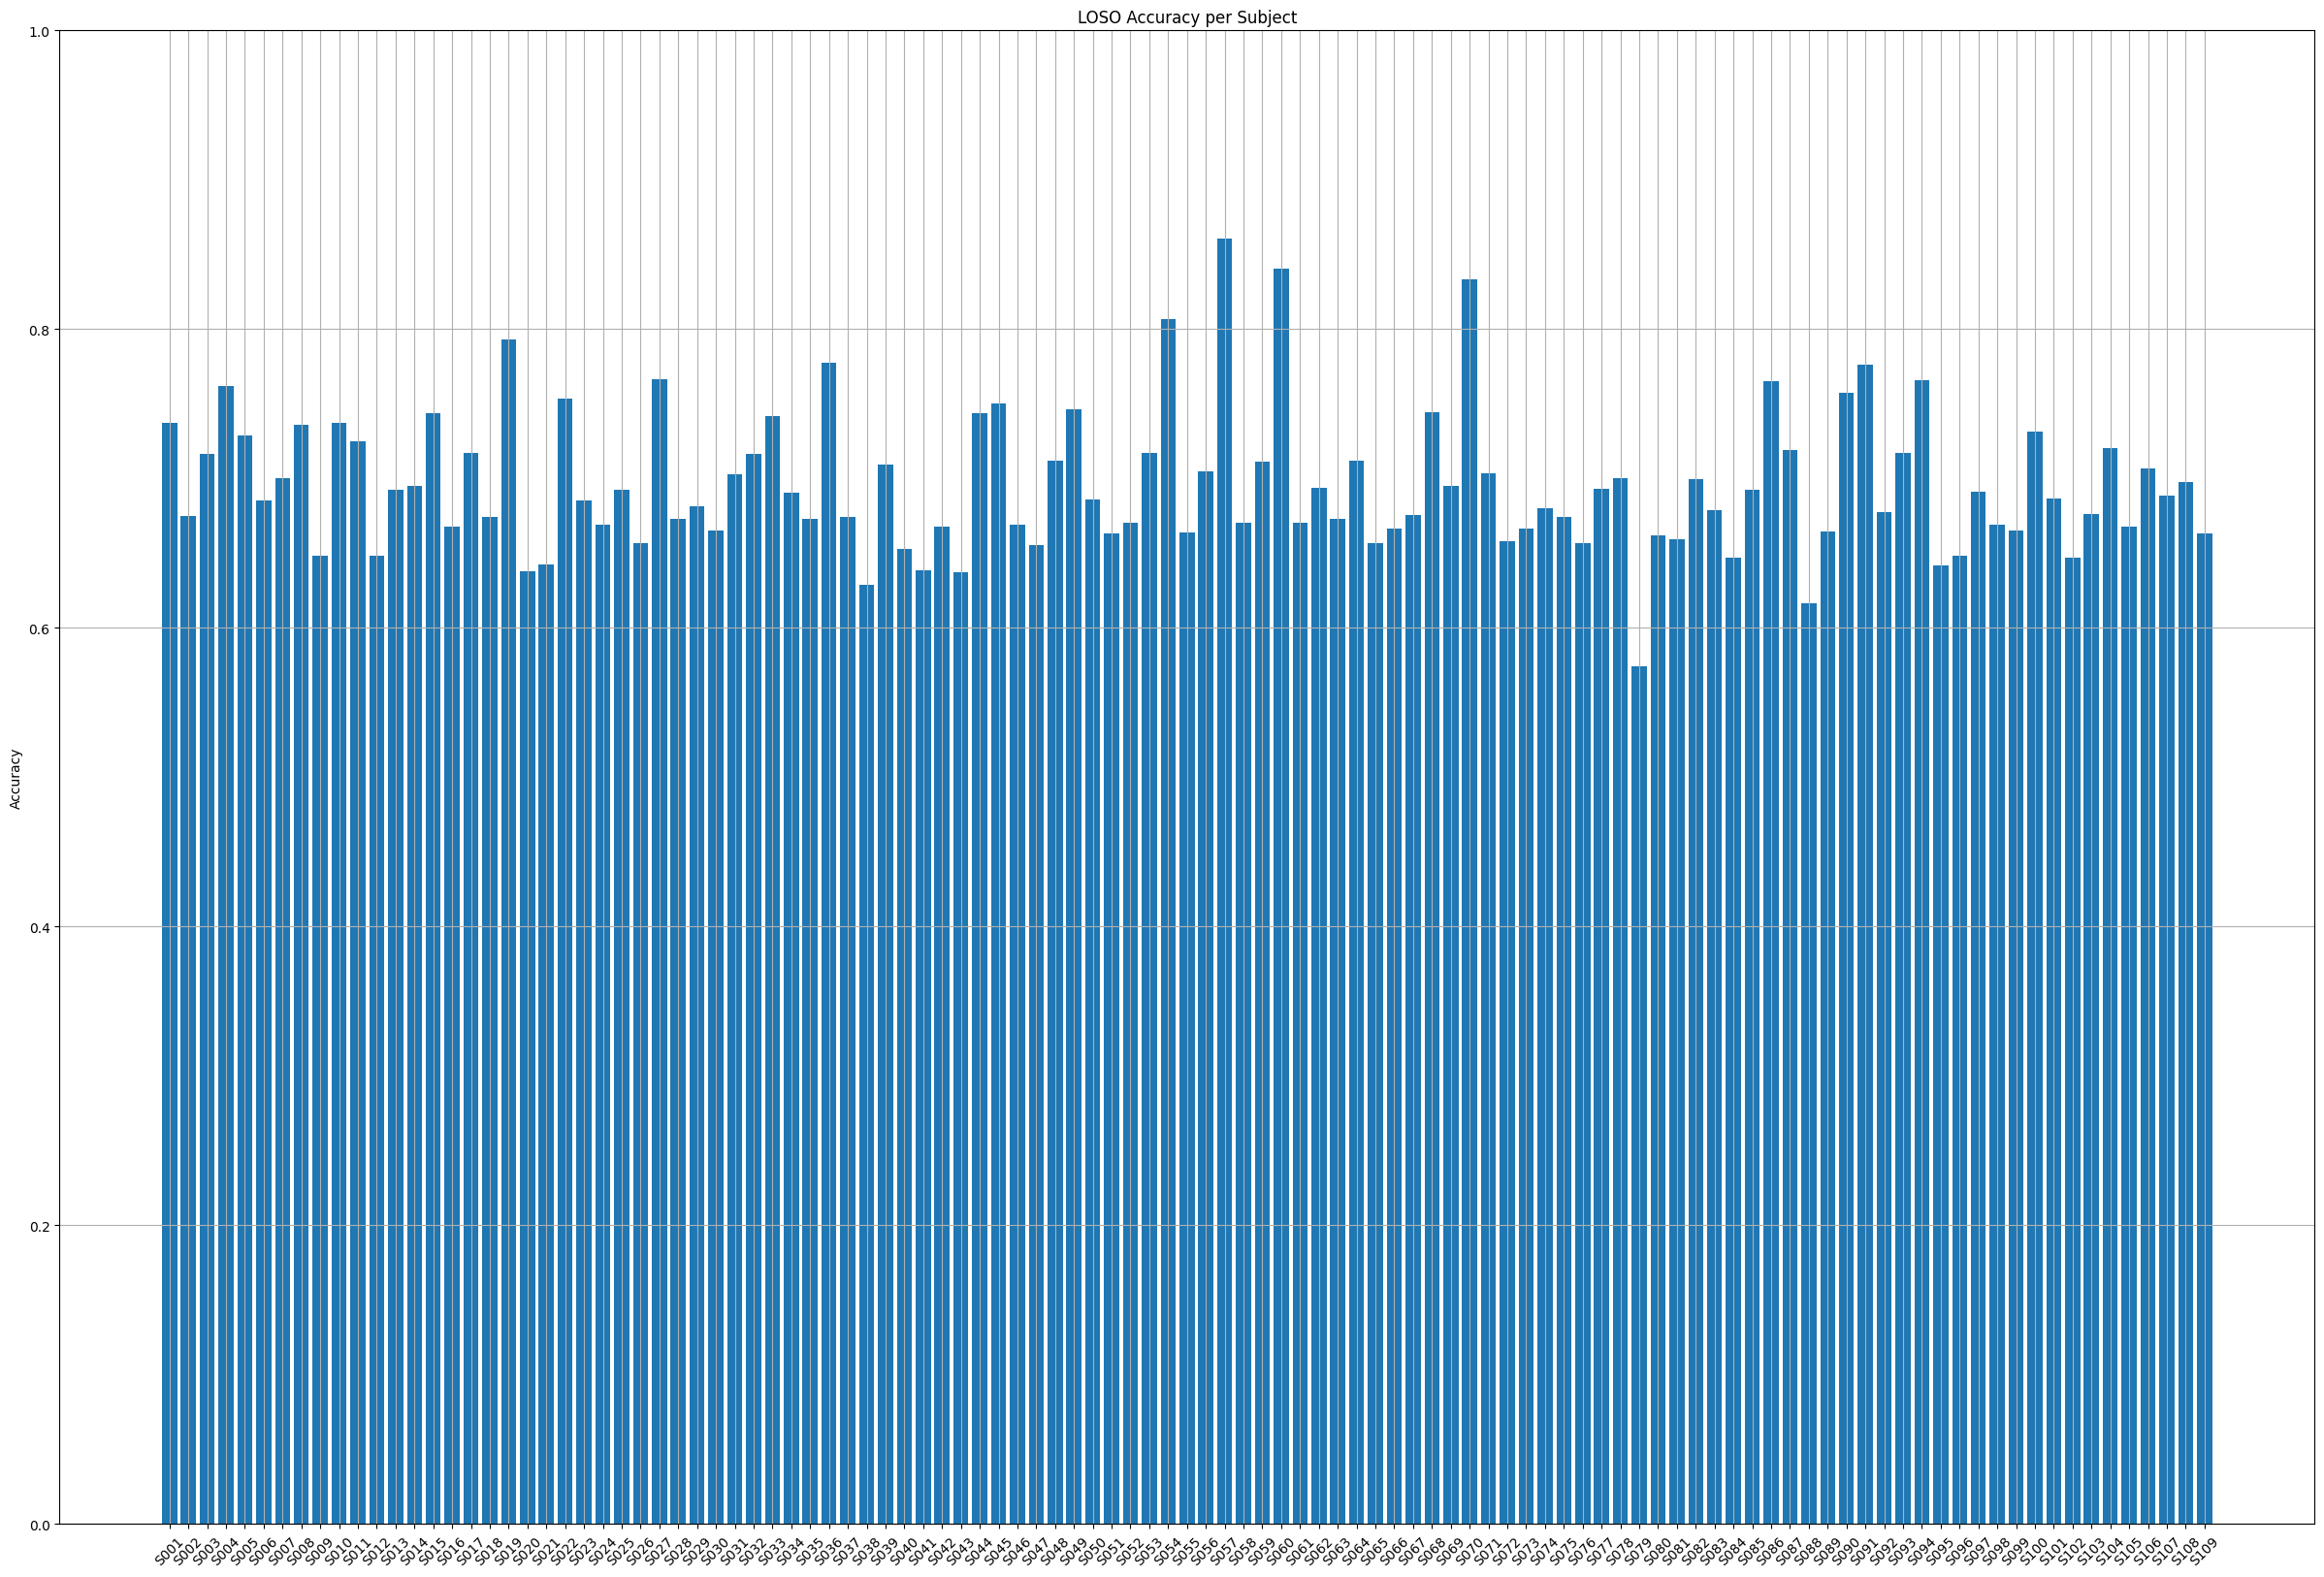

In [18]:
import matplotlib.pyplot as plt

subjects = list(results.keys())
accuracies = list(results.values())

plt.figure(figsize=(30, 20))
plt.bar(subjects, accuracies)
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("LOSO Accuracy per Subject")
plt.grid(True)
plt.show()


In [19]:
import pandas as pd

# Assuming `results` is a dictionary like {'S001': 0.65, 'S002': 0.71, ...}
df = pd.DataFrame(list(results.items()), columns=["Subject", "Accuracy"])
df.to_csv("eegnet_loso_results.csv", index=False)


ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (3).

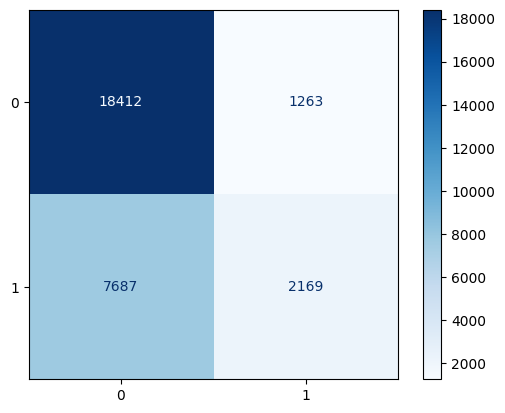

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

all_preds = []
all_true = []

# Re-run the test phase for each subject to collect all predictions
for test_subj in valid_subjects:
    X_test, y_test = all_data[test_subj]
    X_train = np.concatenate([all_data[s][0] for s in valid_subjects if s != test_subj])
    y_train = np.concatenate([all_data[s][1] for s in valid_subjects if s != test_subj])

    train_loader = DataLoader(EEGDataset(X_train, y_train), batch_size=64, shuffle=True)
    test_loader = DataLoader(EEGDataset(X_test, y_test), batch_size=64, shuffle=False)

    model = EEGNetv2(num_classes=3, channels=X_train.shape[2], samples=X_train.shape[3]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(10):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        for xb, yb in test_loader:
            preds = model(xb.to(device)).argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_true.extend(yb.numpy())

# Compute confusion matrix
cm = confusion_matrix(all_true, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['T1', 'T2', 'T0'])
disp.plot(cmap='Blues', values_format='.0f')
plt.title("Aggregated Confusion Matrix (LOSO)")
plt.show()


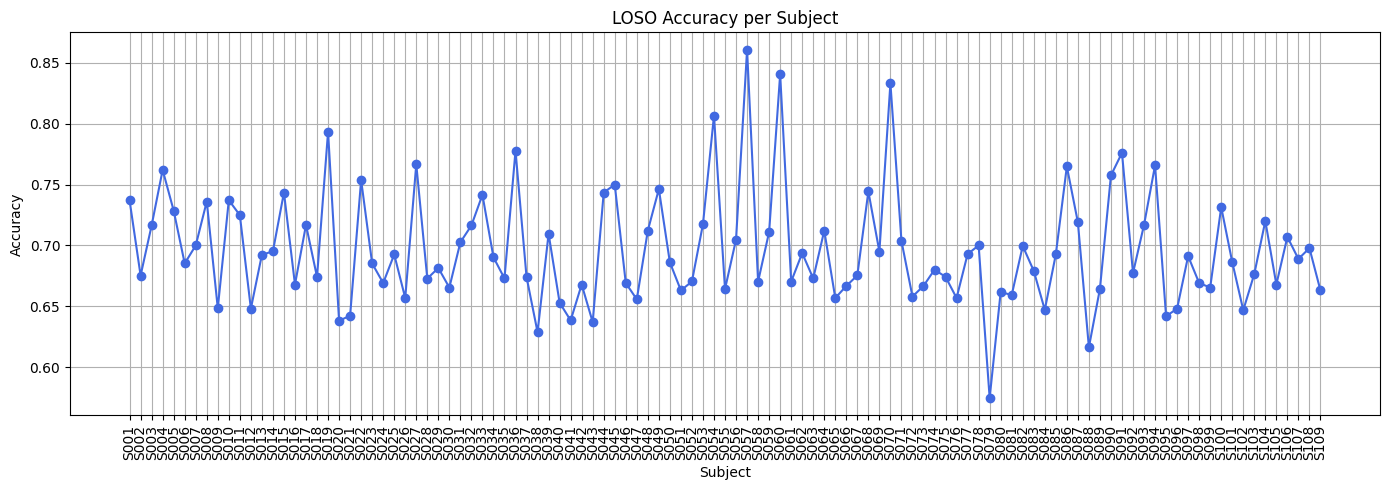

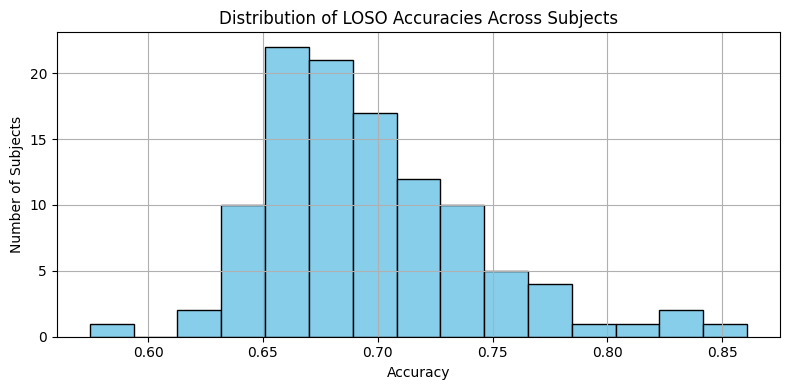

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Paste your accuracy data here (from the table we just made)
subjects = [f"S{str(i).zfill(3)}" for i in range(1, 110)]
accuracies = [
    0.7370, 0.6753, 0.7164, 0.7621, 0.7286, 0.6852, 0.7000, 0.7361, 0.6484, 0.7372,
    0.7249, 0.6481, 0.6923, 0.6952, 0.7435, 0.6679, 0.7169, 0.6741, 0.7934, 0.6381,
    0.6423, 0.7537, 0.6852, 0.6691, 0.6926, 0.6568, 0.7667, 0.6728, 0.6815, 0.6654,
    0.7026, 0.7164, 0.7416, 0.6903, 0.6729, 0.7778, 0.6741, 0.6287, 0.7096, 0.6530,
    0.6384, 0.6679, 0.6370, 0.7435, 0.7500, 0.6691, 0.6557, 0.7122, 0.7463, 0.6861,
    0.6630, 0.6704, 0.7175, 0.8067, 0.6642, 0.7048, 0.8608, 0.6703, 0.7111, 0.8407,
    0.6703, 0.6937, 0.6729, 0.7122, 0.6568, 0.6667, 0.6754, 0.7444, 0.6949, 0.8333,
    0.7037, 0.6580, 0.6667, 0.6801, 0.6742, 0.6568, 0.6929, 0.7000, 0.5746, 0.6618,
    0.6592, 0.6996, 0.6791, 0.6471, 0.6926, 0.7649, 0.7191, 0.6163, 0.6643, 0.7575,
    0.7761, 0.6773, 0.7169, 0.7658, 0.6418, 0.6481, 0.6912, 0.6691, 0.6654, 0.7315,
    0.6863, 0.6468, 0.6766, 0.7201, 0.6679, 0.7070, 0.6889, 0.6978, 0.6630
]

# Plot 1: Accuracy per subject
plt.figure(figsize=(14, 5))
plt.plot(subjects, accuracies, marker='o', linestyle='-', color='royalblue')
plt.xticks(rotation=90)
plt.ylabel("Accuracy")
plt.xlabel("Subject")
plt.title("LOSO Accuracy per Subject")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Histogram of accuracy distribution
plt.figure(figsize=(8, 4))
plt.hist(accuracies, bins=15, color='skyblue', edgecolor='black')
plt.xlabel("Accuracy")
plt.ylabel("Number of Subjects")
plt.title("Distribution of LOSO Accuracies Across Subjects")
plt.grid(True)
plt.tight_layout()
plt.show()
